In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.cluster.hierarchy import fcluster
import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
traindf = pd.read_parquet('train.parquet', engine='pyarrow')

In [2]:
traindf.describe()

,horizon,ts_index,feature_a,feature_b,feature_c,feature_d,feature_e,feature_f,feature_g,feature_h,...,feature_ca,feature_cb,feature_cc,feature_cd,feature_ce,feature_cf,feature_cg,feature_ch,y_target,weight
count,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.337414e+06,5.278949e+06,...,5.337374e+06,5.337414e+06,5.334779e+06,4.937300e+06,5.061585e+06,5.101025e+06,5.297770e+06,5.337414e+06,5.337414e+06,5.337414e+06
mean,9.258638e+00,1.963320e+03,8.868155e+01,8.567391e+00,8.564846e+00,8.565059e+00,8.562926e+00,8.564357e+00,8.566521e+00,5.912386e-03,...,-2.811133e-01,-1.781311e-01,-4.609584e-01,-8.239401e-01,-2.288152e-02,1.472680e+00,1.062790e+00,2.323426e+00,-6.659048e-01,1.642788e+07
std,9.206252e+00,9.970220e+02,5.603141e+01,4.869982e+00,4.869406e+00,4.871465e+00,4.870096e+00,4.868880e+00,4.868368e+00,7.923729e-03,...,1.081776e+00,5.281133e-01,1.667862e+00,3.243581e+00,1.728989e-01,1.491990e+00,1.303983e+00,2.092968e+00,3.252764e+01,6.027074e+09
min,1.000000e+00,1.000000e+00,0.000000e+00,1.300042e-01,1.300016e-01,1.300009e-01,1.300028e-01,1.300075e-01,1.300021e-01,0.000000e+00,...,-9.311414e+01,-3.690332e+01,-1.346736e+02,-2.475901e+02,-7.684573e+00,6.128199e-03,1.606530e-02,0.000000e+00,-2.201882e+03,0.000000e+00
25%,1.000000e+00,1.148000e+03,4.000000e+01,4.350043e+00,4.350582e+00,4.346282e+00,4.346104e+00,4.347559e+00,4.348113e+00,3.744142e-04,...,-1.023971e-01,-1.325353e-01,-6.327619e-02,-1.022825e-01,-4.320754e-02,1.173612e-01,8.029312e-02,1.000000e+00,-1.290776e-01,1.553378e+01
50%,3.000000e+00,2.036000e+03,8.400000e+01,8.568381e+00,8.563840e+00,8.567354e+00,8.560350e+00,8.564697e+00,8.565921e+00,1.308027e-03,...,-1.306394e-02,-1.727560e-02,-1.316598e-02,-1.568063e-03,-1.886561e-03,1.197156e+00,1.594703e-01,2.000000e+00,-5.774818e-04,1.699384e+03
75%,1.000000e+01,2.814000e+03,1.330000e+02,1.278265e+01,1.278253e+01,1.278491e+01,1.278212e+01,1.278137e+01,1.278288e+01,1.047050e-02,...,-3.128947e-04,-2.017864e-04,-1.610013e-03,-5.537199e-04,1.675410e-02,2.524100e+00,1.991925e+00,3.000000e+00,5.106807e-02,1.641908e+05
max,2.500000e+01,3.601000e+03,2.130000e+02,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.109517e-01,...,0.000000e+00,-1.733807e-10,-9.195158e-11,4.884884e-05,2.642112e+00,1.363492e+01,1.056441e+01,1.000000e+01,2.314411e+03,1.391222e+13


## Drop entries in top and bottom 2.5% of y_target values

Target min: -2201.8815779044935
Target max: 2314.4111524982895


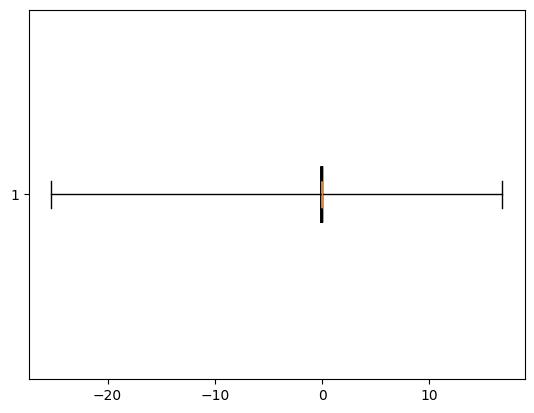

<Figure size 20000x300 with 0 Axes>

In [3]:
target_series = pd.Series(traindf['y_target'])

print(f'Target min: {min(target_series)}')
print(f'Target max: {max(target_series)}')

fig, ax = plt.subplots()
plt.figure(figsize=(200, 3))
ax.boxplot(target_series, vert=False, notch=True, showfliers=False, whis=[2.5,97.5])
plt.show()

In [4]:
print(f'Entries before: {len(traindf)}')

lower_bound = traindf['y_target'].quantile(0.025)
upper_bound = traindf['y_target'].quantile(0.975)
traindf = traindf[traindf['y_target'].between(lower_bound, upper_bound)]

print(f'Entries after: {len(traindf)}')

Entries before: 5337414
Entries after: 5070542


In [ ]:
print(traindf.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Index: 5070542 entries, 0 to 5337413
Data columns (total 94 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   code          object 
 2   sub_code      object 
 3   sub_category  object 
 4   horizon       int32  
 5   ts_index      int32  
 6   feature_a     int32  
 7   feature_b     float64
 8   feature_c     float64
 9   feature_d     float64
 10  feature_e     float64
 11  feature_f     float64
 12  feature_g     float64
 13  feature_h     float64
 14  feature_i     float64
 15  feature_j     float64
 16  feature_k     float64
 17  feature_l     float64
 18  feature_m     float64
 19  feature_n     float64
 20  feature_o     float64
 21  feature_p     float64
 22  feature_q     float64
 23  feature_r     float64
 24  feature_s     float64
 25  feature_t     float64
 26  feature_u     float64
 27  feature_v     float64
 28  feature_w     float64
 29  feature_x     float64
 30  feature_y     float64
 

## Fill empty values

In [5]:
highest_empty_values = traindf.isnull().sum().sort_values(ascending=False)[:10]

for feature in highest_empty_values.index:
    null_count = traindf[feature].isnull().sum()
    zero_count = (traindf[feature].values == 0).sum()
    df_len = len(traindf)

    print(f'Feature: {feature}')
    print(f'Null count: {null_count}')
    print(f'Null percent: {null_count*100/df_len}')
    print(f'Zero count: {zero_count}')
    print(f'Zero percent: {zero_count*100/df_len}')
    print(f'Combined count: {zero_count+zero_count}')
    print(f'Combined percent: {(zero_count+null_count)*100/df_len}')
    print()



Feature: feature_at
Null count: 661717
Null percent: 13.050222244485894
Zero count: 1855358
Zero percent: 36.590920655030565
Combined count: 3710716
Combined percent: 49.64114289951646

Feature: feature_by
Null count: 587841
Null percent: 11.593257683300918
Zero count: 0
Zero percent: 0.0
Combined count: 0
Combined percent: 11.593257683300918

Feature: feature_ay
Null count: 451766
Null percent: 8.909619523908884
Zero count: 1551358
Zero percent: 30.595506358097417
Combined count: 3102716
Combined percent: 39.505125882006304

Feature: feature_cd
Null count: 399825
Null percent: 7.885251714708211
Zero count: 0
Zero percent: 0.0
Combined count: 0
Combined percent: 7.885251714708211

Feature: feature_ce
Null count: 271022
Null percent: 5.345030176261236
Zero count: 0
Zero percent: 0.0
Combined count: 0
Combined percent: 5.345030176261236

Feature: feature_cf
Null count: 235191
Null percent: 4.6383798812829085
Zero count: 0
Zero percent: 0.0
Combined count: 0
Combined percent: 4.6383798812

count    4.408825e+06
mean     3.414494e+03
std      1.404742e+04
min      0.000000e+00
25%      0.000000e+00
50%      2.082953e+01
75%      9.289349e+02
max      5.504714e+05
Name: feature_at, dtype: float64


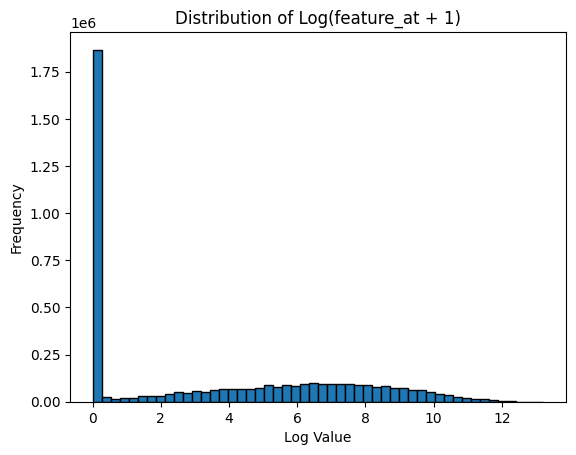

In [7]:
print(traindf['feature_at'].describe())

plt.hist(np.log1p(traindf['feature_at']), bins=50, edgecolor='black')
#plt.hist(traindf['feature_at'], bins=50, edgecolor='black')
plt.title('Distribution of Log(feature_at + 1)')
plt.xlabel('Log Value')
plt.ylabel('Frequency')
plt.show()

count    4.482701e+06
mean    -6.895940e-02
std      3.098222e-01
min     -3.022303e+01
25%     -2.717710e-02
50%     -3.871989e-03
75%     -4.071581e-04
max     -1.679419e-09
Name: feature_by, dtype: float64


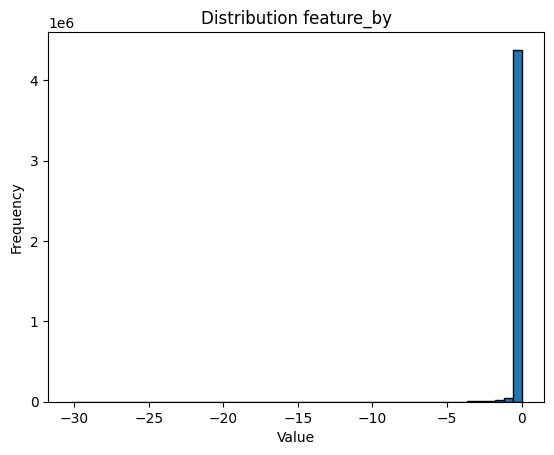

In [22]:
print(traindf['feature_by'].describe())

#plt.hist(np.log1p(traindf['feature_by']), bins=50, edgecolor='black')
plt.hist(traindf['feature_by'], bins=50, edgecolor='black')
plt.title('Distribution feature_by')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

count    4.618776e+06
mean     4.255352e+03
std      1.544016e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.007224e+02
75%      1.826091e+03
max      6.008947e+05
Name: feature_ay, dtype: float64


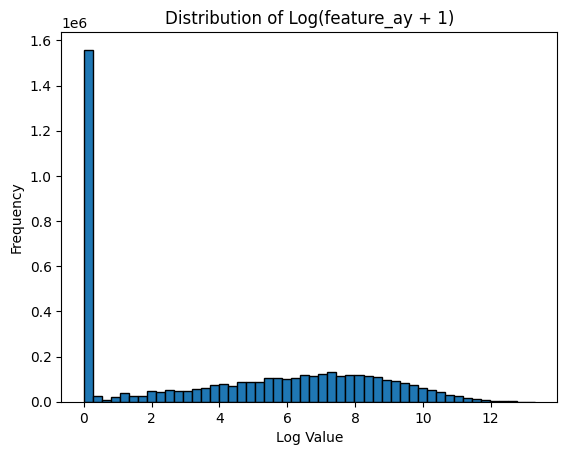

In [23]:
print(traindf['feature_ay'].describe())

plt.hist(np.log1p(traindf['feature_ay']), bins=50, edgecolor='black')
#plt.hist(traindf['feature_ay'], bins=50, edgecolor='black')
plt.title('Distribution of Log(feature_ay + 1)')
plt.xlabel('Log Value')
plt.ylabel('Frequency')
plt.show()

count    4.670717e+06
mean    -4.836989e-01
std      1.903950e+00
min     -2.475901e+02
25%     -8.435030e-02
50%     -1.306806e-03
75%     -5.314537e-04
max      4.884884e-05
Name: feature_cd, dtype: float64


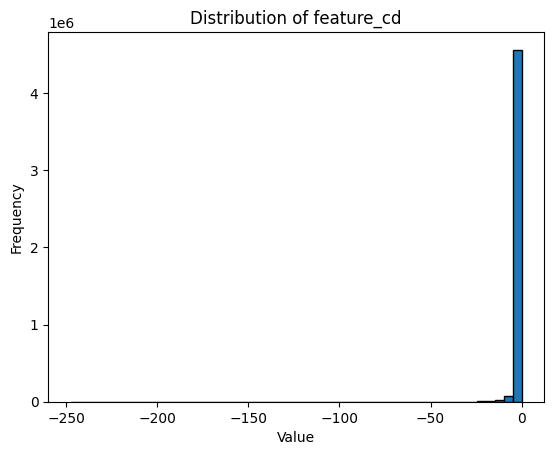

In [26]:
print(traindf['feature_cd'].describe())

#plt.hist(np.log1p(traindf['feature_cd']), bins=50, edgecolor='black')
plt.hist(traindf['feature_cd'], bins=50, edgecolor='black')
plt.title('Distribution of feature_cd')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Since the top missing values have such a high percent missing, I'll replace the missing values with mean/median, but also create another ohe column to represent that this was a missing value (probably for at, by, ay, and cd). The rest will just be replaced with mean/median

In [5]:
features_with_empty_values = traindf.isnull().sum().sort_values()

print(features_with_empty_values)

id                   0
code                 0
sub_code             0
sub_category         0
horizon              0
                 ...  
feature_ce      271022
feature_cd      399825
feature_ay      451766
feature_by      587841
feature_at      661717
Length: 94, dtype: int64


In [6]:
ohe_cols = ['feature_at', 'feature_by', 'feature_ay', 'feature_cd']
ignore_cols = ['id', 'code', 'sub_code', 'sub_category', 'horizon', 'y_target', 'weight']

for col in traindf.columns:
    if col not in ignore_cols:
        #ohe cols with the most missing values (preserve potentially important data)
        if col in ohe_cols:
            traindf[f'{col}_is_missing'] = traindf[col].isna().astype(int)

        median_val = traindf[col].median()
        traindf[col] = traindf[col].fillna(median_val)

## Encoding (one hot for sub_category and horizon, target for code, sub_code, ts_index)

In [7]:
traindf = pd.get_dummies(traindf, columns=['sub_category', 'horizon'], dtype=int)
print(traindf.columns)

Index(['id', 'code', 'sub_code', 'ts_index', 'feature_a', 'feature_b',
       'feature_c', 'feature_d', 'feature_e', 'feature_f',
       ...
       'feature_cd_is_missing', 'sub_category_DPPUO5X2',
       'sub_category_NQ58FVQM', 'sub_category_PHHHVYZI',
       'sub_category_PZ9S1Z4V', 'sub_category_V8BKY1IV', 'horizon_1',
       'horizon_3', 'horizon_10', 'horizon_25'],
      dtype='str', length=105)


In [8]:
unique_codes = traindf['code'].unique()
print(f'Num unique codes: {len(unique_codes)}')
#print((traindf['code'].values == 'W2MW3G2L'))


for code in unique_codes:
    vals = traindf.loc[traindf['code']== code, 'y_target'].describe()
    print(code)
    print(vals)
    print()


Num unique codes: 23
W2MW3G2L
count    305116.000000
mean         -0.022722
std           0.374298
min          -5.356244
25%          -0.123233
50%          -0.011418
75%           0.077935
max           6.830730
Name: y_target, dtype: float64

OSJL3A7Y
count    564314.000000
mean         -0.059196
std           1.775622
min         -18.404994
25%          -0.564471
50%          -0.053768
75%           0.356812
max          16.766957
Name: y_target, dtype: float64

660DZME0
count    263892.000000
mean         -0.006400
std           1.920014
min         -18.612452
25%          -0.629113
50%          -0.054805
75%           0.462994
max          16.760777
Name: y_target, dtype: float64

2RBMUWP1
count    158973.000000
mean         -1.413805
std           7.198599
min         -25.252250
25%          -4.541290
50%          -0.521588
75%           2.160971
max          16.766522
Name: y_target, dtype: float64

QAQDDTPJ
count    42790.000000
mean        -3.958803
std         11.537337
min 

In [9]:
encode_cols = ['code', 'sub_code', 'ts_index']
for col in encode_cols:
    traindf[f'{col}_median'] = traindf.groupby(col)['y_target'].transform('median')
    traindf.drop(columns=[col], inplace=True)
    print(f"Success: Encoded and dropped '{col}'")


print(traindf.head())

Success: Encoded and dropped 'code'
Success: Encoded and dropped 'sub_code'
Success: Encoded and dropped 'ts_index'
                                     id  feature_a  feature_b  feature_c  \
0  W2MW3G2L__J0G2B0KU__PZ9S1Z4V__25__89         29  16.364093   7.464023   
1   W2MW3G2L__J0G2B0KU__PZ9S1Z4V__1__89         53   2.858806   5.050617   
2   W2MW3G2L__J0G2B0KU__PZ9S1Z4V__3__89         51   9.585452   1.076268   
3  W2MW3G2L__J0G2B0KU__PZ9S1Z4V__10__89         44   8.840588  15.034634   
4  W2MW3G2L__J0G2B0KU__PZ9S1Z4V__25__90         28   2.303825   7.696209   

   feature_d  feature_e  feature_f  feature_g  feature_h  feature_i  ...  \
0   5.966933   1.622184  10.261360   4.914369   0.000467   0.023686  ...   
1  15.906651  10.879453   3.072151   4.091032   0.000467   0.023686  ...   
2   9.004147  16.740490  15.166901  11.427983   0.000467   0.023686  ...   
3   4.170780   1.584433   5.383462   3.099428   0.000467   0.023686  ...   
4  12.896100  13.830051   0.552439   5.731490  

## Drop features with low correlation to y_target

In [10]:
'''
drop_cols = ['id', 'weight']
col_list = traindf.columns.tolist()
for col in drop_cols:
    if col in col_list:
        traindf = traindf.drop(columns=[col])
        print(f'{col} dropped')
        '''
drop_cols = ['id', 'weight']

existing_cols = [c for c in drop_cols if c in traindf.columns]

traindf.drop(columns=existing_cols, inplace=True)

In [11]:
#target_corr = traindf.corr()['y_target'].abs().sort_values(ascending=False)
target_corr = traindf.drop(columns=['y_target']).corrwith(traindf['y_target']).abs().sort_values(ascending=False)

print(target_corr)

code_median    0.210339
feature_u      0.151143
feature_am     0.149893
feature_bm     0.148162
feature_bo     0.144865
                 ...   
feature_e      0.000342
feature_f      0.000316
feature_bi     0.000307
feature_aj     0.000300
feature_b      0.000085
Length: 102, dtype: float64


code_median    0.210339
feature_u      0.151143
feature_am     0.149893
feature_bm     0.148162
feature_bo     0.144865
                 ...   
feature_e      0.000342
feature_f      0.000316
feature_bi     0.000307
feature_aj     0.000300
feature_b      0.000085
Length: 102, dtype: float64


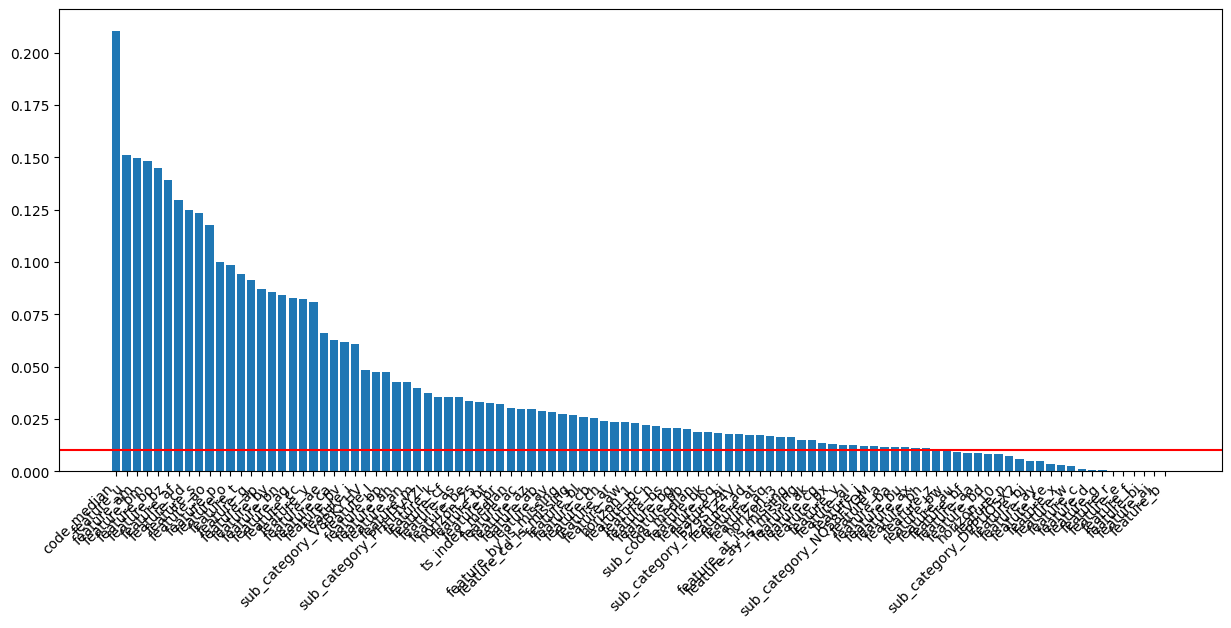

In [12]:
corr_series = pd.Series(data=target_corr, index=target_corr.index)
#corr_series = corr_series.drop(labels=['y_target'])
print(corr_series)

plt.figure(figsize=(15, 6))
plt.bar(corr_series.index, corr_series)
plt.axhline(y=0.01, color='r')
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
low_corr_cols = target_corr[target_corr < 0.01].index.tolist()

print(f"{len(low_corr_cols)} columns with correlation < 0.01")

if low_corr_cols:
    traindf.drop(columns=low_corr_cols, inplace=True)
    print("Columns dropped successfully.")
else:
    print("No columns met the criteria to be dropped.")

print(f"New shape: {traindf.shape}")

21 columns with correlation < 0.01
Columns dropped successfully.
New shape: (5070542, 82)


## Drop/combine cols within clusters (ie remove redundancy)

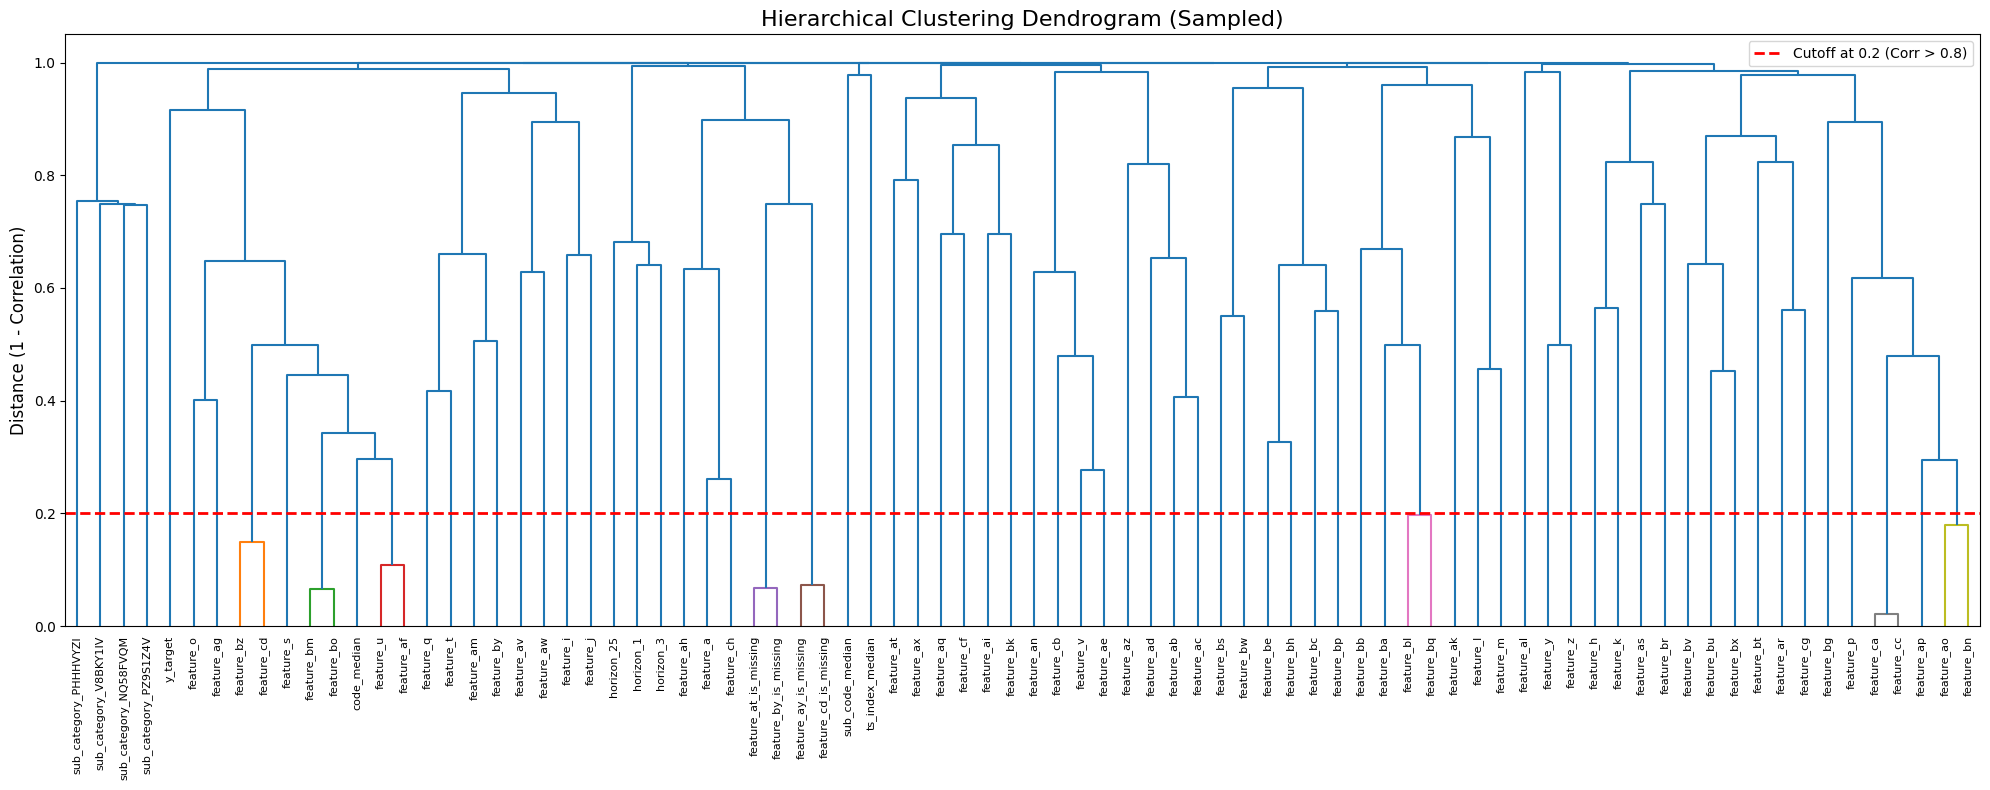

In [14]:
samples = int(len(traindf)/2)
sample_corr = traindf.sample(n=samples, random_state=42).corr().astype('float32').abs()

dissimilarity = 1 - sample_corr
distance_matrix = squareform(dissimilarity, checks=False)

Z = linkage(distance_matrix, method='complete')

plt.figure(figsize=(20, 8))
dendrogram(
    Z,
    labels=sample_corr.columns,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=0.2
)


cutoff = 0.2
plt.axhline(y=cutoff, color='r', linestyle='--', linewidth=2, label=f'Cutoff at {cutoff} (Corr > {1-cutoff:.1f})')

plt.title('Hierarchical Clustering Dendrogram (Sampled)', fontsize=16)
plt.ylabel('Distance (1 - Correlation)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
cluster_labels = fcluster(Z, t=cutoff, criterion='distance')

cluster_map = {}
feature_names = sample_corr.columns

for feature, cluster_id in zip(feature_names, cluster_labels):
    if cluster_id not in cluster_map:
        cluster_map[cluster_id] = []
    cluster_map[cluster_id].append(feature)

features_to_drop = []
for cluster_id, features in cluster_map.items():
    if len(features) > 1:
        corrs = {f: target_corr.get(f, 0) for f in features}

        winner = max(corrs, key=corrs.get)

        for f in features:
            if f != winner:
                features_to_drop.append(f)
                
print(f"Dropping {len(features_to_drop)} redundant features.")
traindf.drop(columns=features_to_drop, inplace=True)

print(f"Final Column Count: {traindf.shape[1]}")


Dropping 8 redundant features.
Final Column Count: 74


## Model Training

## XGB Model

In [ ]:
X = traindf.drop(columns=['y_target'])
y = traindf['y_target']

print(f"Training on {X.shape[0]} rows and {X.shape[1]} features.")

# 2. Split data into Training and Validation sets
# We use a validation set to stop training early if the model stops improving
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize the XGBoost Model with CUDA
model = xgb.XGBRegressor(
    objective='reg:squarederror', # Standard for regression
    n_estimators=2000,            # High number, we rely on early_stopping to find the sweet spot
    learning_rate=0.05,           # Lower rate = better accuracy but slower training
    max_depth=8,                  # Depth of trees (6-10 is standard)
    
    # --- GPU SETTINGS ---
    device='cuda',                # Use NVIDIA GPU
    tree_method='hist',           # 'hist' is the fastest method for large data on GPU
    
    # Optional: Manage GPU memory chunks if you hit VRAM limits
    # max_bin=256,
    
    random_state=42,
    n_jobs=-1                     # Use all CPU cores for data loading steps
)

# 4. Train the Model
print("Starting training on GPU...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100  # Print progress every 100 trees
)

# 5. Evaluate
preds = model.predict(X_val)
rmse = mean_squared_error(y_val, preds, squared=False)
print(f"\nFinal Validation RMSE: {rmse:.5f}")

# 6. Plot Feature Importance
# This verifies which of your 74 remaining features actually matter
plt.figure(figsize=(10, 12))
xgb.plot_importance(model, max_num_features=30, height=0.5, importance_type='weight')
plt.title("Top 30 Feature Importances")
plt.show()

Training on 5070542 rows and 73 features.
Starting training on GPU...


## LGBM Model

In [ ]:


# Create the dataset object (This does NOT load everything into RAM immediately in the same way)
# 'free_raw_data=False' allows you to keep the raw data if you have RAM, 
# but setting it to True (default) frees the raw arrays after constructing the histograms.

X = traindf.drop(columns=['y_target'])
y = traindf['y_target']

print(f"Training on {X.shape[0]} rows and {X.shape[1]} features.")

# 2. Split data into Training and Validation sets
# We use a validation set to stop training early if the model stops improving
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,       # Controls complexity (31 is standard)
    'learning_rate': 0.05,
    'feature_fraction': 0.9, # Select 90% of features per tree (prevents overfitting & saves memory)
    
    # --- MEMORY OPTIMIZATIONS ---
    'device': 'gpu',         # Use GPU (make sure you installed lightgbm --gpu)
    'max_bin': 63,           # Lowering bins from 255 to 63 drastically cuts RAM with minimal accuracy loss
    'force_col_wise': True   # Forces column-wise building which is more RAM efficient for large N
}

print("Training LightGBM...")
bst = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)] # Built-in callback for early stopping
)

preds = bst.predict(X_val)

Training on 5070542 rows and 73 features.
Training LightGBM...
